Author: Saman Paidar Nia

In [1]:
# Get important libraries for this class.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import csv
import random
import math
#--------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from IPython.display import clear_output
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm

In [2]:
class Similarity_func:
    def sigmoidal_normalize(self, X):
        X= (X - min(X)) / (max(X) - min(X))
        return X

In [3]:
class Cosine_Similarity(Similarity_func):
    def get_matrix(self, data):
        data = normalize(data, axis=0)
        m = squareform(pdist(data, 'cosine'))
        m = np.dot(LA.matrix_power(np.diag(np.sum(m, 0)), -1), m)
        m = np.apply_along_axis(self.sigmoidal_normalize, 1, m)
        np.fill_diagonal(m, 0.)
        return m

In [4]:
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        labels=self.labels
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]
        return data_shuffle, labels_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)

In [5]:
def read_wine_data(similarity):
    with open('../Autoencoder_vs_Spectral_on_Wine/Wine_Dataset/wine_data.csv') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader, None) # skip header
        dataset = list(csvreader)
    random.shuffle(dataset)
    datatrain = dataset[:int(len(dataset))]
    data = [data for data in datatrain]
    labels = [data[13] for data in datatrain]   
    return Similarity_Dataset_Iterator(data, labels, similarity)

In [6]:
# Call Nearest_Neighbors_Similarity or Cosine_Similarity as similarity dataset.
data_set_train = read_wine_data(Cosine_Similarity())

In [7]:
def k_means_(X, n_cluster):
    kmeans_centroids,_ =  kmeans(X,n_cluster)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

In [8]:
def spectral_clustering(X, n_cluster):
    D_ = np.matrix(np.diag(np.sum(X,0)))
    D_ = D_**(-1)
    L = np.dot(np.dot(D_, X),D_)
    eigenvectors = np.linalg.eig(L)[1]
    X = np.real(eigenvectors[:,0:n_cluster])
    X = normalize(X, norm='l2', axis=0)
    return k_means_(X, n_cluster)

In [9]:
n_input = data_set_train.data_size #---------------- Number of input data.
n_hidden_1 = 128 #---------------------------------- The autoencoder hidden layer 1.
n_node_layers = (n_input+n_hidden_1)#---- Collect nodes.

In [10]:
def encoder(x, n_code, phase_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(x, [n_input, n_hidden_1], [n_hidden_1], phase_train)              
        with tf.variable_scope("code"):
            code = layer(hidden_1, [n_hidden_1, n_code], [n_code], phase_train)
    return code

In [11]:
def decoder(code, n_code, phase_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(code, [n_code, n_hidden_1], [n_hidden_1], phase_train)        
        with tf.variable_scope("output"):
            output = layer(hidden_1, [n_hidden_1, n_input], [n_input], phase_train)
    return output

In [12]:
def layer_batch_norm(x, n_out, phase_train):
    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

In [13]:
def layer(input, weight_shape, bias_shape, phase_train):
    weight_init = tf.random_normal_initializer(stddev=(1.0 / weight_shape[0]) ** 0.5)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.sigmoid(layer_batch_norm(logits, weight_shape[1], phase_train))

In [14]:
def loss(output, x):
    with tf.variable_scope("training"):
        train_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(output, x)), 1))
        train_summary_op = tf.summary.scalar("train_cost", train_loss)
        return train_loss

In [15]:
def training(cost, learning_rate, beta1, beta2, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [16]:
def evaluate(output, x):
    with tf.variable_scope("validation"):
        val_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        val_summary_op = tf.summary.scalar("val_cost", val_loss)
        return val_loss

In [17]:
# Parameters
n_layers = 3 #---------------------------- Number of Neural Networks Layers.
beta1 = 0.9 #----------------------------- The decay rate 1.  
beta2 = 0.999 #--------------------------- The decay rate 2.
learning_rate = (beta1/n_input) #--------- The learning rate, it should be a floating point value.
n_batch = math.ceil(n_input/n_layers) #--- Number of selection data in per step.
n_backpro = math.ceil(n_input/n_batch) #-- Number of Backpro in per epoc
n_epoch = math.ceil(n_input/n_layers) #--- The time priod of train.
n_cluster = 3 #--------------------------- Number of clusters.
n_diplay = int(n_epoch/n_layers) #------- Number of runnig the K-Means and NMI.
n_code = str(64) #--------------------------The number of output dimension value.
results=[] #------------------------------ A list to keep all NMI scores.
loss_cost=[] #---------------------------- A list to keep all training evaluations.
steps=[] #-------------------------------- A list to keep all steps.

In [18]:
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_model"):                
        x = tf.placeholder("float", [None, n_input])   
        phase_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), phase_train)
        output = decoder(code, int(n_code), phase_train)
        cost = loss(output, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
        eval_optimizer = evaluate(output, x)
        summary_op = tf.summary.merge_all()
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

In [19]:
# Training cycle
for epoch in tqdm(range(n_epoch+1)):
    average_cost = 0.
    # Fit training with Backpropagation using batch data.
    for i in range(n_backpro):
        miniData, _ = data_set_train.next_batch(n_batch)
        sess.run([train_optimizer, cost], feed_dict={x: miniData,
                                                     phase_train: True})
        sess.run(eval_optimizer, feed_dict={x: miniData,
                                        phase_train: True})
        ############## End of the Backpropagation with Random Walk ##############
    randomData, _ = data_set_train.next_batch(data_set_train.data_size)     
    _, new_cost = sess.run([train_optimizer, cost], feed_dict={x: data_set_train.whole_dataset()[0],
                                                               phase_train: True})
    average_cost += new_cost/n_backpro
            ############## End of the Optimization ##############
    # Save the results after per (Size of input / n_layers) epochs.
    if epoch % n_diplay == 0 or epoch == n_epoch:
        ae_codes = sess.run(code, feed_dict={x: data_set_train.whole_dataset()[0],
                                         phase_train: False})
        # Running K-Means on Embedding Data.
        idx = k_means_(ae_codes, n_cluster)
        ae_nmi = normalized_mutual_info_score(data_set_train.whole_dataset()[1], idx)
        results.append(ae_nmi)    
        steps.append(epoch)
        loss_cost.append(average_cost)    
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step. "
              .format(ae_nmi,new_cost, epoch))

 32%|█████████████████████████▉                                                        | 19/60 [00:02<00:04,  9.35it/s]

NMI Score for AE is: 0.93 and new cost is: 0.94 in 20 step. 


 65%|█████████████████████████████████████████████████████▎                            | 39/60 [00:03<00:02, 10.34it/s]

NMI Score for AE is: 1.00 and new cost is: 0.45 in 40 step. 


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 59/60 [00:05<00:00, 10.84it/s]

NMI Score for AE is: 1.00 and new cost is: 0.19 in 60 step. 


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.75it/s]


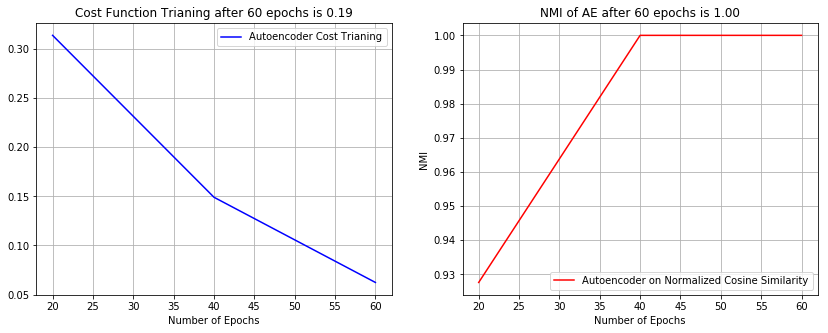

In [20]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.errorbar(steps, loss_cost, label='Autoencoder Cost Trianing', color='b')
plt.xlabel('Number of Epochs')
plt.grid()
plt.title(('Cost Function Trianing after {:d} epochs is {:0.2f}').format(n_epoch,new_cost))
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.errorbar(steps, results, label='Autoencoder on Normalized Cosine Similarity', color='r')
plt.xlabel('Number of Epochs')
plt.ylabel('NMI')
plt.grid()
plt.title(('NMI of AE after {:d} epochs is {:0.2f}').format(n_epoch,ae_nmi))
plt.legend(loc='best')
plt.show()

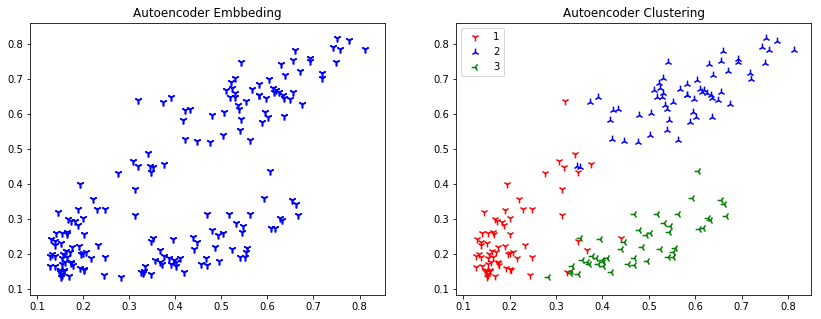

In [23]:
origin_label = np.array(data_set_train.whole_dataset()[1]).astype(int)
colors = [('r', '1'),('b', '2'),('g','3')]
plt.figure(figsize=(14, 5))
for num in range(3):
    plt.subplot(1,2,1)
    plt.scatter(ae_codes[:,0], ae_codes[:,1], 60, color='b', marker='1')
    plt.title("Autoencoder Embbeding")
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter([ae_codes[:,0][i] for i in range(len(idx)) if idx[i] == num],
                [ae_codes[:,1][i] for i in range(len(idx)) if idx[i] == num],
                60, label=str(num+1), color = colors[num][0], marker=colors[num][1])
    plt.title("Autoencoder Clustering")
    plt.legend()
plt.show()

In [24]:
indx = spectral_clustering(data_set_train.whole_dataset()[0], n_cluster)
spectral_nmi = (normalized_mutual_info_score(data_set_train.whole_dataset()[1], indx))
print(("Spectral CS:          {:0.2f}".format(spectral_nmi)))
#-----------------------------------------------------------------------------------------------
k_means_indx = k_means_(data_set_train.whole_dataset()[0], n_cluster)
k_means_nmi_ = (normalized_mutual_info_score(data_set_train.whole_dataset()[1], k_means_indx))
print(("KMeans CS:            {:0.2f}".format(k_means_nmi_)))
#-----------------------------------------------------------------------------------------------
print("Autoencoder:          {:0.2f}".format(ae_nmi))

Spectral CS:          0.93
KMeans CS:            0.94
Autoencoder:          0.95
